### Try to define ENSO 3.4 index in a "simple" way

Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). 

Computation recipe in detail: 
- Compute area averaged total SST from Niño 3.4 region.
- Compute monthly climatology for area averaged total SST from Niño 3.4 region.
- Subtract climatology from area averaged total SST time series to obtain anomalies. 
- Smooth the anomalies with a 5-month running mean.
- Normalize the smoothed values by its standard deviation over the climatological period.

This recipe for calculating ENSO requires some rolling mean. We omit the rolling mean here and directly take **sst anomaly index** instead. And as climatology we use the full time span.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from climate_index_collection.data_loading import (
    find_data_files,
    load_data_set,
)

In [2]:
FOCI_alldata = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
CESM_alldata = load_data_set(data_path="../data/test_data/", data_source_name="CESM")

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [8]:
def el_nino_southern_oscillation_34(data_set, sst_name="sea-surface-temperature"):
    """Calculate the El Nino Southern Oscillation 3.4 index (ENSO 3.4)

    Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
    the index is derived from equatorial pacific sea-surface temperature anomalies in a box 
    borderd by 5°S, 5°N, 120°W and 170°W.
     
    Computation is done as follows: 
    1. Compute area averaged total SST from Niño 3.4 region.
    2. Compute monthly climatology for area averaged total SST from Niño 3.4 region.
    3. Subtract climatology from area averaged total SST time series to obtain anomalies. 
    4. Normalize anomalies by its standard deviation over the climatological period.
    
    Note: Usually the index is smoothed by taking some rolling mean over 5 months before 
    normalizing. We omit the rolling mean here and directly take sst anomaly index instead, 
    to preserve the information in full detail. And as climatology we use the complete time span,
    since we deal with model data.
    
    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing an SST field.
    sst_name: str
        Name of the Sea-Surface Temperature field. Defaults to "sea-surface-temperature".

    Returns
    -------
    xarray.DataArray
        Time series containing the ENSO 3.4 index.

    """
    
    mask = (
        (data_set[sst_name].coords["lat"] >= -5) & (data_set[sst_name].coords["lat"] <= 5) &
        (data_set[sst_name].coords["lon"] >= 190) & (data_set[sst_name].coords["lat"] <= 240)
    ) 
    
    weights = np.cos(np.deg2rad(data_set[sst_name].lat))
    
    sst_nino34 = (
        data_set[sst_name]
        .where(mask)
        .weighted(weights)
        .mean(("lat", "lon"))
    )
    
    climatology = (
        sst_nino34
        .groupby("time.month")
        .mean("time")    
    )
    
    std_dev = (
        sst_nino34
        .std("time")
    )
    
    ENSO34_index = (sst_nino34.groupby("time.month") - climatology) / std_dev
    ENSO34_index = ENSO34_index.rename("ENSO34")
    
    return ENSO34_index

In [11]:
ENSO34_FOCI = el_nino_southern_oscillation_34(data_set=FOCI_alldata, sst_name="sea-surface-temperature")
ENSO34_CESM = el_nino_southern_oscillation_34(data_set=CESM_alldata, sst_name="sea-surface-temperature")

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


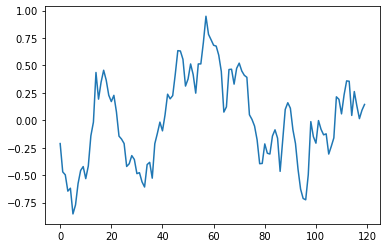

In [5]:
plt.plot(ENSO34_FOCI.values)

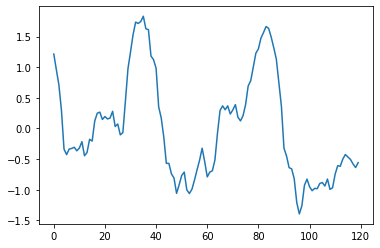

In [12]:
plt.plot(ENSO34_CESM.values)

In [17]:
# Test for zero mean in every month:
print("FOCI:\n",ENSO34_FOCI.groupby("time.month").mean("time").values)
print("\nCESM:\n",ENSO34_CESM.groupby("time.month").mean("time").values)

FOCI:
 [-5.61994895e-14  7.04991621e-15  5.62216940e-14 -4.21759849e-14
 -2.10775841e-14  1.40665257e-14  7.01105840e-15 -5.62210001e-14
  4.91912067e-14 -3.51454976e-14 -5.55111512e-18  7.02771175e-14]

CESM:
 [ 5.86197757e-15 -3.52384788e-14 -2.04725126e-14  4.44089210e-17
 -1.17461596e-14  2.34923192e-14  3.52162743e-14 -2.05613304e-14
  2.93320923e-14 -2.05391260e-14  2.90878432e-15 -2.05391260e-14]


In [10]:
# Test for correct index name:
ENSO34_FOCI.name

'ENSO34'